In [1]:
from sympy.abc import s, z
import sympy as sp
import numpy as np
import control.matlab as m
from utils.units import basis, u
from IPython.display import display
l, c, r, rl, rc = sp.symbols("L C R r_L r_C")

gp_ = (r+c*r*rl*s)/((c*l*r+c*l*rc)*s**2+(l+c*r*rc+c*r*rl+c*rc*rl)*s+r+rl)

gp_

(C*R*r_L*s + R)/(R + r_L + s**2*(C*L*R + C*L*r_C) + s*(C*R*r_C + C*R*r_L + C*r_C*r_L + L))

In [21]:
params = {
    l: 400*u.uH,
    c: 700*u.uF,
    r: 6.22*u.ohm,
    rl: .1*u.ohm,
    rc: .1*u.ohm
}
sp.Dict(params)

{C: 700*microfarad, L: 400*microhenry, R: 6.22*ohm, r_C: 0.1*ohm, r_L: 0.1*ohm}

In [3]:
from utils.units.sympy_helpers import to_basis, SI
gp = to_basis(SI, gp_.subs(params)).simplify()
gp

(0.0004354*second*s + 6.22)/(1.7696e-6*second**2*s**2 + 0.0012778*second*s + 6.32)

In [4]:
nu = basis()
nu

NumericalBasis(mapper=QuantityMapper(salt=-438716472056438932), proxy_system=<UnitSystem: (meter, kilogram, second, ampere, mole, candela, kelvin)>)

In [5]:
from utils.ctrl import expr2sys
gp_tf = expr2sys(nu.to_numeric(gp, as_expr=True), s)
gp_tf

TransferFunction(array([9.72646888e-04, 6.22000000e+00]), array([8.83097517e-06, 2.85449746e-03, 6.32000000e+00]))

In [6]:
from utils.ctrl import sys2expr
dt = 1/(10*u.kHz)

gp_dtf = m.c2d(gp_tf, nu[dt])
gp_d = sys2expr(gp_dtf, z)
gp_d

(0.0407044281477866*z - 0.00689506811957163)/(1.0*z**2 - 1.89598406643148*z + 0.930336985302596)

In [7]:
from utils.ctrlsys import pole_specs, z_map
from utils.math import sp_reim as reim
import control.matlab as m

def rlocus_cond(dp, z, fb):
    return fb.subs(z, dp)+1

k1, k2 = sp.symbols("K_1 K_2", real=True)

# controlador pd predictivo
gc_d = (k1*z+k2)/(z**2)

ts = 3*u.ms
mp = 5*u.percent

_, dp_s = pole_specs(nu[ts], nu[mp])

dp = z_map(dp_s, nu[dt])

k1_, k2_ = map(float, sp.nsolve(
    reim(rlocus_cond(dp, z, gp_d*gc_d)),
    (k1, k2), (.5, .5)
))
k1_, k2_

(3.613720120062023, -3.8167197110274365)

In [8]:
from utils.ctrlsys import autotune, feedforward

k1_, k2_ = autotune({k1: k1_, k2: k2_},
    z, m.tf("z"),
    gc_d,
    nu[mp]*.95, nu[ts]*.95,
    gp_dtf,
    1, config=feedforward, iter=30)
k1_, k2_

(4.527497855980496, -5.0078584165103175)

In [9]:
from utils.ctrl import expr2sys
gc_dtf = expr2sys(gc_d.subs({k1: k1_, k2: k2_}), z)
gc_dtf

TransferFunction(array([ 4.52749786, -5.00785842]), array([1, 0, 0]), True)

In [10]:
from utils.ctrlsys import feedforward
gclff_dtf = feedforward(gp_dtf, gc_dtf)
gcl_dtf = m.feedback(gp_dtf*gc_dtf)

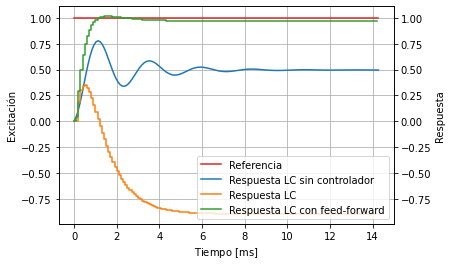

In [11]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.ms, 1, 1
)

plot_step(m.feedback(gp_tf), label="Respuesta LC sin controlador")
plot_step(gcl_dtf, label="Respuesta LC")
plot_step(gclff_dtf, label="Respuesta LC con feed-forward")
plot_ref(label="Referencia")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
ax_e.grid()
set_gain_and_legend_loc(1, "lower right")

/home/fakui/.local/lib/python3.9/site-packages/control/timeresp.py:293: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


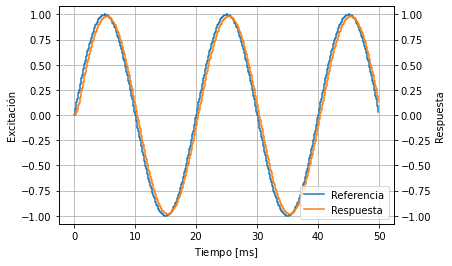

In [12]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp
from utils.ctrlsys import zoh_stairs

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.ms, 1, 1
)

t = np.arange(0, nu[50*u.ms], nu[dt])
ref = np.sin(2*np.pi*nu[50*u.Hz]*t)
out, _, _ = m.lsim(gclff_dtf, ref, T=t)

ax_e.plot(*zoh_stairs(t, ref), c=next_color(), label="Referencia")
ax_r.plot(*zoh_stairs(t, out), c=next_color(), label="Respuesta")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
ax_e.grid()
set_gain_and_legend_loc(1, "lower right")

In [22]:
from utils.ctrlsys import difference_eq
from utils.ctrl import siso_numden

def my_diff_eq(sys, ff=False):
    e, u = map(sp.Function, "e u".split(" "))
    k = sp.symbols("k", real=True)
    res = difference_eq(*siso_numden(sys), e, u, k)
    if not ff:
        return res
    r = sp.Function("r")
    lhs, rhs = res.args
    return sp.Eq(lhs, rhs + r(k))

my_diff_eq(gc_dtf, ff=True).n(4)

Eq(u(k), -5.008*e(k - 2) + 4.528*e(k - 1) + r(k))

In [14]:
kmi, n, w1 = sp.symbols("K_{mi} n, \\omega_1")

gres = kmi*s/(s**2+(n*w1)**2)
gres

K_{mi}*s/(\omega_1**2*n**2 + s**2)

In [15]:
from utils.units.sympy_helpers import without_units
def usubs(var, val, expr):
    return without_units(expr,
        lambda dummify, expr: expr.subs(
            var, dummify(val)))

def var_in(var, unit, expr):
    return usubs(var, var/unit, expr)

In [23]:
uwu = u.rps
w1_ = 50*uwu*sp.pi*2
freqs = {1: 50, 3: 50, 5: 30, 7: 0}
gcrs = [
    gres.subs({w1: w1_, kmi: gain*uwu, n: nth})
        for nth, gain in freqs.items()
]
list(map(display, gcrs)); None

50*radians_per_second*s/(10000*pi**2*radians_per_second**2 + s**2)

50*radians_per_second*s/(90000*pi**2*radians_per_second**2 + s**2)

30*radians_per_second*s/(250000*pi**2*radians_per_second**2 + s**2)

0

In [25]:
from utils.ratpolys import ratpoly_inv

# plz work
for nth, gain in freqs.items():
    sys = expr2sys(
        nu.to_numeric(gres.subs({w1: w1_, kmi: uwu, n: nth}), as_expr=True), s)
    sys_d = m.c2d(sys, nu[dt])
    display(sys_d)
    num, den = ratpoly_inv(*siso_numden(sys_d.minreal()))
    display(my_diff_eq(sys_d.minreal()).n(4))

    for i, coeff in enumerate(num):
        print(f"#define a{i}_{nth} {coeff:1.12f}")
    *rest, div = den
    for i, coeff in enumerate(rest):
        print(f"#define b{i}_{nth} {coeff:1.12f}")
    print(f"#define kmi_{nth} {gain/div:1.12f}")
    print()

TransferFunction(array([ 1.5915428e-05, -1.5915428e-05]), array([ 1.      , -1.999975,  1.      ]), 0.00022339156823620102)

Eq(u(k), -1.592e-5*e(k - 2) + 1.592e-5*e(k - 1) - 1.0*u(k - 2) + 2.0*u(k - 1))

#define a0_1 -0.000015915428
#define a1_1 0.000015915428
#define a2_1 0.000000000000
#define b0_1 1.000000000000
#define b1_1 -1.999975000052
#define kmi_1 50.000000000000



TransferFunction(array([ 1.59148975e-05, -1.59148975e-05]), array([ 1.      , -1.999775,  1.      ]), 0.00022339156823620102)

Eq(u(k), -1.591e-5*e(k - 2) + 1.591e-5*e(k - 1) - 1.0*u(k - 2) + 2.0*u(k - 1))

#define a0_3 -0.000015914897
#define a1_3 0.000015914897
#define a2_3 0.000000000000
#define b0_3 1.000000000000
#define b1_3 -1.999775004219
#define kmi_3 50.000000000000



TransferFunction(array([ 1.59138365e-05, -1.59138365e-05]), array([ 1.        , -1.99937503,  1.        ]), 0.00022339156823620102)

Eq(u(k), -1.591e-5*e(k - 2) + 1.591e-5*e(k - 1) - 1.0*u(k - 2) + 1.999*u(k - 1))

#define a0_5 -0.000015913836
#define a1_5 0.000015913836
#define a2_5 0.000000000000
#define b0_5 1.000000000000
#define b1_5 -1.999375032551
#define kmi_5 30.000000000000



TransferFunction(array([ 1.59122451e-05, -1.59122451e-05]), array([ 1.        , -1.99877513,  1.        ]), 0.00022339156823620102)

Eq(u(k), -1.591e-5*e(k - 2) + 1.591e-5*e(k - 1) - 1.0*u(k - 2) + 1.999*u(k - 1))

#define a0_7 -0.000015912245
#define a1_7 0.000015912245
#define a2_7 0.000000000000
#define b0_7 1.000000000000
#define b1_7 -1.998775125047
#define kmi_7 0.000000000000



In [17]:
gcr_tfs = [expr2sys(nu.to_numeric(gcr, as_expr=True), s) for gcr in gcrs]
list(map(display, gcr_tfs)); None

TransferFunction(array([8.7418549, 0.       ]), array([1.00000000e+00, 0.00000000e+00, 3.01694174e+03]))

TransferFunction(array([8.7418549, 0.       ]), array([1.00000000e+00, 0.00000000e+00, 2.71524757e+04]))

TransferFunction(array([5.24511294, 0.        ]), array([1.00000000e+00, 0.00000000e+00, 7.54235436e+04]))

In [18]:
gcr_dtfs = [m.c2d(gcr_tf, nu[dt]) for gcr_tf in gcr_tfs]
list(map(display, gcr_dtfs)); None

TransferFunction(array([ 0.00499918, -0.00499918]), array([ 1.        , -1.99901312,  1.        ]), 0.0005719609917751371)

TransferFunction(array([ 0.0049926, -0.0049926]), array([ 1.        , -1.99112393,  1.        ]), 0.0005719609917751371)

TransferFunction(array([ 0.00298768, -0.00298768]), array([ 1.        , -1.97537668,  1.        ]), 0.0005719609917751371)

In [19]:
[display(my_diff_eq(gcr_dtf).n(4)) for gcr_dtf in gcr_dtfs]; None

Eq(u(k), -0.004999*e(k - 2) + 0.004999*e(k - 1) - 1.0*u(k - 2) + 1.999*u(k - 1))

Eq(u(k), -0.004993*e(k - 2) + 0.004993*e(k - 1) - 1.0*u(k - 2) + 1.991*u(k - 1))

Eq(u(k), -0.002988*e(k - 2) + 0.002988*e(k - 1) - 1.0*u(k - 2) + 1.975*u(k - 1))

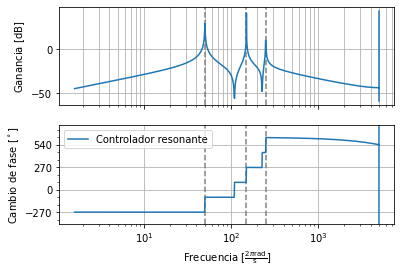

In [20]:
from utils.mpl import set_datalim, nu_sharex_axes
from utils.ctrl import bode_axes
from functools import partial

fig, (ax_gain, ax_phase), add_bode_, add_deg_locator = bode_axes()

add_bode = partial(add_bode_, deg=False, dB=True)

for freq in freqs.keys():
    for ax in (ax_gain, ax_phase):
        ax.axvline(nu[w1_*freq], c="gray", linestyle="--")

w = np.geomspace(10*nu[u.rad/u.s], nu[sp.pi/dt], 1000)[:-1]
add_bode(sum(gcr_dtfs), label="Controlador resonante", omega=w)

add_deg_locator(270)

nu_sharex_axes(nu, ax_phase, ax_gain,
    ("Frecuencia", 2*sp.pi*u.rad/u.s),
    ("Cambio de fase", u.deg),
    ("Ganancia", 1),
    y2_in_db=True)

ax_gain.grid(which='both')
ax_phase.grid()
set_datalim(ax_phase, y=(-nu[360*u.deg], nu[360*u.deg]*2))

ax_phase.legend(); None

#fig.savefig(out_dir / "resp_parte1_compensado_bode.svg")